# Kapitel 11 - Logistic Regression als simples Neuronales Netz

## 11.1. Kapitelübersicht <a class="anchor" id="11-1"/>

Bevor wir uns der Implementierung von Neuronalen Netzen in Keras widmen, werden wir in diesem Kapitel das Klassifizierungsverfahren <b>Logistic Regression</b> als Neuronales Netz implementieren. Der eigentliche <a href="https://github.com/Kulbear/deep-learning-coursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/Logistic%20Regression%20with%20a%20Neural%20Network%20mindset.ipynb">Code</a> wurde aus dem Coursera Kurs "Deep Learning" entnommen. Dort wurde in der ersten <a href="https://github.com/Kulbear/deep-learning-coursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/Logistic%20Regression%20with%20a%20Neural%20Network%20mindset.ipynb">Programmieraufgabe</a> ein Datensatz mit Katzenbildern klassifiziert, wobei Bilder die Klassen "Katze" oder "Keine Katze" besaßen. Logistic Regression wurde dort als einfaches simples Neuronales Netz interpretiert. Der Code funktioniert sehr gut mit unserem Korpus, jedoch musste dieser vorher auf zwei Kategorien reduziert werden, da eine Multiclass Klassifizierung als Anschauungsbeispiel zu komplex wäre. Die Idee dieses Kapitels ist es, einen Einblick in die Implementation eines Neuronalen Netzes zu erhalten. Dieser Einblick umfasst die Grundschritte der Neuronalen Netze wie Initalisierung, Forward Propagation und Backward Propagation. Später werden wir auf die Deep-Learning-Bibliothek <b>Keras</b> zurückgreifen, bei der jedoch die zentralen Schritten des Trainings eines Neuronalen Netzes weniger präsent sind und die Layer in kurzen Ausdrücken zusammengefasst sind. 

<b>Abschnittsübersicht</b><br>

[11.1. Kapitelübersicht](#11-1)<br>
[11.2. Reduzierung des Korpus auf 2 Klassen](#11-2)<br>
[11.3. Implementierung des Neuronalen Netzes](#11-3)<br>
[11.3.1. Die Sigmoid-Funktion](#11-3-1)<br>
[11.3.2. Parameterinitalisierung mit Nullen](#11-3-2)<br>
[11.3.3. Forward und Backward propagation](#11-3-3)<br>
[11.3.4. Optimierung](#11-3-4)<br>
[11.3.5. Vorrausage](#11-3-5)<br>
[11.3.6. Das Modell](#11-3-6)<br>
[11.4. Mögliche Fehler](#11-4)<br>


Am Ende dieses Kapitel werden wir folgende Themen behandelt und/oder vertieft haben:
- Umwandlung von Sparse Matrizen zu Dense Matrizen
- Implementierungen Neuronaler Netze in numpy in fünf Schritten:
    - Implementierung der Sigmoid-Funktion
    - Parameterinitalisierung mit Nullen
    - Forward Propagation und Backward Propagation
    - Implementierung der Aktivierungsfunktion
- Voraussagen von Neuronalen Netzen
- Visualisierung der Cost-Score Kurve

## 11.2. Reduzierung des Korpus auf 2 Klassen <a class="anchor" id="11-2"/>

Um unser Korpus mit dem später entwickelten binären Classifier trainieren zu können, müssen wir es auf zwei Klassen reduzieren. Dazu wählen wir die Kategorien "Computerspiel nach Plattform" und "Internet" aus.

#### Laden und Reduzierung des Korpus

In [1]:
import pandas as pd
corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv", index_col=0)

In [6]:
corpus_computer = corpus[corpus.category == "Computerspiel nach Plattform"]
corpus_internet = corpus[corpus.category == "Internet"]
tinycorpus = corpus_computer.append(corpus_internet, ignore_index=True)
tinycorpus.head()

,id,category,length,text
0,2646,Computerspiel nach Plattform,353,Ballyhoo ist ein Computerspiel der US-amerikan...
1,2644,Computerspiel nach Plattform,379,Balance of Power ist ein Computer-Strategiespi...
2,2645,Computerspiel nach Plattform,415,Ballblazer ist ein Zweispieler-Computer-Sports...
3,2647,Computerspiel nach Plattform,417,Barbarian : The Ultimate Warrior und Barbarian...
4,2652,Computerspiel nach Plattform,359,Beyond Zork ( kompletter Titel Beyond Zork : T...


In [7]:
tinycorpus.tail()

,id,category,length,text
395,342,Internet,182,Soribada ( koreanisch 'Ton herunterladen ' ) ...
396,343,Internet,766,Streetspotr ist eine Plattform für standortbas...
397,344,Internet,158,The Real News ist ein globaler Online-Videonac...
398,333,Internet,930,OnLive war eine interaktive Kompressionsmethod...
399,290,Internet,396,"Clickjacking ist eine Technik , bei der ein Co..."


#### Aufteilung in Trainings- und Testdatensätze

Ein wichtige Veränderung ist hier die Umwandlung der Sparse Matrix `vector` in eine Dense Matrix. Dies erfolgt mit `toarray()`. Ohne diese würde das Neuronale Netz nicht arbeiten können (der erste Fehler würde schon bei der Implementierung der Sigmoid-Funktion erfolgen).

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np


labels = LabelEncoder().fit_transform(tinycorpus["category"])
vector  = TfidfVectorizer().fit_transform(tinycorpus["text"]).toarray()


X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    random_state=42)

#### Umformung der Trainingsdatensätze

Eines der häufigsten Fehler, die bei der Arbeit mit Neuronalen Netzen gemacht wird, ist die falsche Benutzung von Matrix- und Vektordimensionen. Schauen wir uns die Dimensionen der Trainings- und Testdatensätze an. 

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(320, 31654)
(80, 31654)
(320,)
(80,)


`X_train` hat die Dimension `(320, 31654)`. Diese hat die Form `(n,m)`, wobei `n` für die Anzahl der Zeilen und `m` für die Anzahl der Spalten steht. Die Matrix hat also 320 Zeilen und 31654 Spalten. Um unser Modell nutzen zu können, muss jede Spalte einen Datensatz repräsentieren. Bis jetzt repräsentieren die Zeilen jedoch einen Datensatz, weshalb wir die Matrix <u>transponieren</u> (= Zeilen werden zu Spalten und umgekehrt) müssen. Dies können wir mit dem Befehl `.T` durchführen. Da die Labels eindimensionale Matrizen, also Vektoren sind, müssen wir diese nicht transponieren.

In [10]:
X_train = X_train.T
X_test = X_test.T

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31654, 320)
(31654, 80)
(320,)
(80,)


## 11.3. Implementierung des Neuronalen Netzes <a class="anchor" id="11-3"/>

Wir werden nun Logistic Regression als simples Neuronales Netz mit numpy implementieren. Dazu brauchen wir nur fünf Funktionen. Diese werden ausführlich erklärt.

### 11.3.1. Die Sigmoid-Funktion <a class="anchor" id="11-3-1"/>

Wie wir in Kapitel 6 gesehen haben, basiert Logistic Regression auf der <b>Sigmoid-Funktion</b> (oder <b>Logistische Funktion</b>). Diese wandelt jeden Eingabewert in eine Zahl zwischen 0 und 1 um.<br>

$ f(x) = \frac{1}{1\ +\ e^{-x}}$<br>

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [13]:
print(sigmoid(10))
print(sigmoid(0.001))

0.9999546021312976
0.5002499999791666


In [14]:
sigmoid(vector)

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

Die Implementation ist ziemlich simpel. Bereits hier zeigt sich jedoch, wieso wir die Daten gerne als Dense-Matrix vorliegen hätten. Versuchen wir nun einmal, die Daten als Sparse Matrix zu übergeben.

In [15]:
sparse_vector  = TfidfVectorizer().fit_transform(tinycorpus["text"])
sigmoid(sparse_vector)

AttributeError: exp not found

Wir erhalten eine Fehlermeldung, da die numpy-Funktion `exp` nicht mit Sparse Matrizen arbeiten kann.

### 11.3.2. Parameterinitalisierung mit Nullen <a class="anchor" id="11-3-2"/>

Als Nächstes müssen wir die Parameter `w` und `b` mit Nullen initalisieren. Dafür müssen wir jedoch zunächst klären, was `w` und `b` überhaupt sind. Schauen wir uns noch einmal die Formel für Logistic Regression aus Kapitel 6 an:<br>

$ y = \frac{e^{(B0\ +\ B1 \cdot x)}}{1\ +\ e^{(B0\ +\ B1 \cdot x)}}$<br>

Diese Formel ist eine Erweiterung der Formel für <b>Linear Regression</b>, die folgendermaßen aussieht:<br>

$ y = B0 + B1 \cdot x $<br>

$y$ war der Output, der vorausgesagt werden soll und $x$ der Input. $B0$ war der Bias Koeffizient und $B1$ der Koeffizient für $x$. Diese Formel kann auch etwas verändert geschrieben werden:<br>

$ y = w^T \cdot x\ +\ b $<br>

$b$ ist hier der Biaskoeffizient $B0$. $B1$ wird durch eine transponierte Gewichtsmatrix $w$ repräsentiert. Wie in Kapitel 6 sind diese Koeffizienten die Werte, die vom unseren Modell erlernt werden. In Kapitel 6 hatten wir diesen Lernprozess ausgeblendet, in diesem Kapitel werden wir in den nächsten Abschnitten genauer auf ihn eingehen. Die Formel ist nun aber die Formel für die Lineare Regression. Die Formel für die Logistic Regression sieht folgendermaßen aus:<br>

$ y = \frac{e^{(w^T \cdot x\ +\ b)}}{1\ +\ e^{(w^T \cdot x\ +\ b)}}$<br>


Etwas allgemeiner können wir die Formel folgendermaßen formulieren ($\sigma$ steht für die Sigmoid-Funktion):<br>

$ y = \sigma(w^T \cdot x\ +\ b) $<br>

$\sigma$ ist eine sogenannten <b>Aktivierungsfunktion</b>. Neben der Sigmoid-Funktion hatten wir noch die <b>Softmax-Funktion</b> als Aktivierungsfunktion für <b>Multinomial Logistic Regression</b> kennengelernt. Noch allgemeiner könnten wir die Funktion folgendermaßen schreiben, wobei $a$ für eine beliebige Aktivierungsfunktion steht.

$ y = a(w^T \cdot x\ +\ b) $<br>

Diese Formel wird in jedem Neuron unseres Neuronalen Netzwerks angewendet. Graphisch können wir uns das folgendermaßen vorstellen, wobei $a$ die Aktivierungsfunktion ist und $y$ die Funktion:

<img src="tutorialdata/img/nn4_2_edit.png" alt="Neural Network with 2 layers and Neuron labeling" align="center" width="600px;"><br>

`w` und `b` sind also Koeffizienten, die mithilfe eines Neuronalen Netzes erlernt werden. Jedoch müssen wir mit irgendwelchen Werten beginnen, weshalb wir sie hier mit Nullen initalisieren. `b` können wir dabei einfach gleich Null setzen, da `b` ein Skalar (= einzelner Wert) ist. `w` ist jedoch kein Skalar, sondern eine Matrix, dessen Länge bzw. Dimension wir mit `dim` angeben.

In [16]:
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim, 1))
    b = 0

    return w, b

Wir werden später dieser Funktion `dim = 320` übergeben, da wir für jeden Trainingsdatensatz einen Eintrag mit einer Null erstellen wollen.

In [20]:
#initialize_with_zeros(320)

### 11.3.3. Forward und Backward propagation <a class="anchor" id="11-3-3"/>

Nun haben wir unsere Gewichte `w` und `b` initalisiert. Diese müssen jedoch angepasst werden, damit unser Modell sinnvolle Repräsentationen liefert. Würden wir sie nicht verändern, würden unsere Ergebnisse immer gleich bleiben und unser Modell wäre sinnlos. Das Modell muss die Gewichte `w` und `b` also <u>lernen</u>. Dieser Lernprozess findet in der sogenannten <b>Trainingsschleife</b> (englisch: training loop) statt. Diese lässt sich am beste mit der folgenden Grafik beschreiben:<br>

<img src="tutorialdata/img/neuronal_network.png" alt="Neuronal network" align="center" width="300px;"><br><div style="text-align: center; font-size:10px;">CHOLLET, Francois, Deep Learning mit Python und Keras, übers. von Knut LORENZEN, New York 2018, S. 31.</div></img>

Zuerst übergeben wir unsere Daten dem Modell (<b>Eingabe X</b>). Die Daten werden als Matrix repräsentiert, bei der jede Spalte für ein Trainingsbeispiel steht. In unserem Fall stellen 320 Spalten die 320 Trainingsbeispiele dar. Unser Input Layer hat also 320 Dimension, also auch 320 Neuronen. Nun bestimmen wir `w` und `b`, am Anfang noch mit Nullen oder zufälligen Werten. Das Ergebnis ist die Funktion $y$. Jedes unserer Neuronen aktiviert diese Funktion dann mithilfe einer <b>Aktivierungsfunktion $a$</b>. Das können wir hier sehen:<br>
<img src="tutorialdata/img/nn4_2_edit.png" alt="Neural Network with 2 layers and Neuron labeling" align="center" width="400px;">

Am Ende dieses Durchlaufs erhalten wir eine Voraussage $\hat{y}$ (bis jetzt nannten wir dies `y_pred`). Stimmt diese mit dem tatsächlichen Label $y$ (nicht zu verwechseln mit der Funktion $y$) überein, hat unser Modell das Label richtig vorausgesagt. Zu Beginn ist es jedoch sehr unwahrscheinlich, dass unser Modell mit zufälligen Gewichten oder Gewichten bestehend aus Nullen das richtige Label voraussagt. Wir müssen also berechnen, wie sehr das Modell mit der Voraussage falsch gelegen hat. Dies wird mit der <b>Loss Function</b> (deutsch: <b>Verlustfunktion</b>) berechnet. Eine Loss Function berechnet jedoch nur den <b>Loss score</b> (deutsch: Verlustscore) von einem einzigen Trainingsbeispiel. Um die Loss scores aller Trainingsbeispiele zu berechnen, brauchen wir eine <b>Cost Function</b>, die den Durschnitt aller Loss scores für den gesamten Trainingsdatensatz berechnet.<br> Dieser gesamte Schritt wird <b>Forward Propagation</b> genannt. Eine gute Visualisierung bietet dieses <a href="https://www.youtube.com/watch?v=UJwK6jAStmg">Video</a>.<br>

Anhand des Loss scores können nun die Koeffizienten `w` und `b` aktualisiert werden. Diesen Vorgang nennt man <b>Backward Propagation</b>. Wie genau diese Backward Propagation funktioniert, wird in Chollets Buch Kapiteln 2.4.1 - 2.4.4 sehr gut erklärt.

<div class="alert alert-warning">
<b>Aufgabe:</b> Kapitel 2 - Bevor es losgeht: die mathematischen Bausteine eines NNs
    
Lesen Sie noch einmal die Kapitel 2.4.1 - 2.4.4. Versuchen Sie in ein oder zwei Sätzen zu erklären, was <b>gradient descent</b> (deutsch: Gradientenabstieg) ist und wie es funktioniert.
    
</div>

Nun jedoch zur Funktion `propagate`. Sie nimmt als Input die Gewichtsmatrix `w`, den Biaskoeffizienten `b`, die Trainingsdaten `X_train` und die Trainingslabel `y_train`. Wir bestimmen zunächst die Anzahl der Trainingsbeispiele `m`. Danach berechnen wir die Aktivierungsfunktion `A`. Nach dem ersten Aufruf sieht die Matrix `A` folgendermaßen aus:

In [109]:
w, b = initialize_with_zeros(X_train.shape[0])
A = sigmoid(np.dot(w.T, X_train) + b)
A

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

Wir brauchen nun also eine Cost Function, die den Loss score für alle Trainingsbeispiele berechnet. Die Auswahl der Loss Function bzw. der Cost Function hängt von der jeweiligen Klassifizierung ab:
- <b>binary cross entropy</b> für binäre Klassifizierung
- <b>cross entropy</b> für Multiclass Klassifizierung

Da wir hier eine binäre Klassifikation durchführen, verwenden wir die <b>binary cross entropy</b>. Die Formel dafür lautet: <br>

$ \text{binary cross entropy} = - (y\ \cdot log(\hat{y}) + (1−y)\ \cdot log(1−\hat{y}))$

<div class="alert alert-warning">
<b>Aufgabe:</b> Cross entropy
    
Cross entropy ist uns in einer anderen Form bereits in Kapitel 6 begegnet und zwar in Form der <b>Maximum likehood estimation</b>-Methode. Lesen Sie den <a href="https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/">Blog-Eintrag</a> von Jason Brownlee zu <b>Cross entropy</b>. Schauen Sie sich danach die Formel für <b>binary cross entropy</b> an:<br>
    
$ \text{binary cross entropy} = - (y\ \cdot log(\hat{y}) + (1−y)\ \cdot log(1−\hat{y}))$<br>

$y$: das wahre Label<br>
$\hat{y}$: das vorgesagte Label<br>

Setzen Sie folgende Werte für $y$ und $\text{y}$ ein. Was beobachten Sie? Gehen Sie davon aus, dass $log(0)$ berechnet werden kann und $log(0) = -14$. <i>Tipp</i>: $log(1) = 0$.<br>

a) $y = 0$; $\hat{y} = 0$<br>
b) $y = 1$; $\hat{y} = 1$<br>
c) $y = 0$; $\hat{y} = 1$<br>
d) $y = 1$; $\hat{y} = 0$<br>

</div>

Die Loss Function für binary cross entropy ist:<br>

$ L(\hat{y}, y) = - (y\ \cdot log(\hat{y}) + (1−y)\ \cdot log(1−\hat{y}))$.<br><br>

Die Formel für die Cost Function ist:<br>

$ J(w, b)\ =\ -\frac{1}{m} \sum_{i=1}^m \cdot\ L(\hat{y}, y)\ =\ -\frac{1}{m} \sum_{i=1}^m \cdot\ (y^{(i)}\ \cdot log(\hat{y}^{(i)}) + (1−y^{(i)})\ \cdot log(1−\hat{y}^{(i)}))$<br><br>

Diese wird in der Funktion `propagate` in der Variable `cost` gespeichert. `np.squeeze` entfernt hier eindimensionale Einträge aus der Matrix. Damit garantieren wir, dass die Cost Function wirklich nur aus einem Wert besteht und keine redundante Achse enthält. Damit ist die Forward Propagation abgeschlossen. Nun implementieren wir die partiellen Ableitungen für `w` und `b`. Die Formeln dafür lauten folgendermaßen:<br>


$ \frac{\partial J}{\partial w} = \frac{1}{m}\ \text{X_train}\ \cdot(A-\text{y_train})^T$<br>

$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m \cdot\ (a^{(i)}-y^{(i)})$<br>

Diese speichern wir im Dictionary `grads`.

In [21]:
def propagate(w, b, X_train, Y_train):
   
    # m: Anzahl der Trainingsbeispiele
    m = X_train.shape[1]
    
    ### Forward Propagation ###
    
    # Aktivierungsfunktion / Formel für Logistic Regression
    A = sigmoid(np.dot(w.T, X_train) + b) 
    
    # Cost Function
    cost = (- 1 / m) * np.sum(Y_train * np.log(A) + (1 - Y_train) * (np.log(1 - A)))
    cost = np.squeeze(cost)
    
    
    ### Backward Propagation ###
    
    # partiellen Ableitungen
    dw = (1 / m) * np.dot(X_train, (A - Y_train).T)
    db = (1 / m) * np.sum(A - Y_train)


    grads = {"dw": dw,
             "db": db}

    
    return grads, cost

### 11.3.4. Optimierung <a class="anchor" id="11-3-4"/>

Wir haben nun mit `propagate` eine Funktion implementiert, die Forward und Backward Propagation implementiert. Jetzt müssen wir die `optimize` Funktion implementieren, die für mehrere Dinge verantwortlich ist:
- Optimieren über mehrere Iterationen (durch `num_iterations`). Eine Iteration ist ein Durchlaufen der Trainingsschleife.
- Aktualisierung von `w` und `b` mithilfe einer <b>Learning Rate</b> (deutsch: Lernrate). Diese Learning Rate ist ein Hyperparameter, der angibt, wie sehr wir die Gewichtsmatrix `w` und den Bias-Koeffizienten `b` in unserem Neuronalen Netz anpassen wollen.
- Dokumentation des Cost-Scores alle hundert Iterationen.
- Ausgabe des Cost-Scores alle hundert Trainingsbeispiele. Dies kann über `print_cost` gesteuert und "abgeschaltet" werden.
- Speicherung von `w` und `b` in einem Parameter-Dictionary `params`, nachdem die Iterationen abgeschlossen sind.

In [22]:
def optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = False):

    costs = []
    
    for i in range(num_iterations):

        grads, cost = propagate(w, b, X_train, Y_train)

        # Ableitungen aus dem Grads-Dictionary
        dw = grads["dw"]
        db = grads["db"]
        
        
        # Aktualisierung von w und b
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Dokumentiert die Cost-Scores in einer Liste
        if i % 100 == 0:
            costs.append(cost)
        
        # Bei jedem 100ten Trainingsbeispiel wird der Cost-Score ausgegeben
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

### 11.3.5. Voraussage <a class="anchor" id="11-3-5"/>

Zuletzt muss noch eine `predict`-Funktion implementiert werden, die wie die `predict`-Funktion von <b>Scikit learn</b> funktioniert. Wie Voraussagen mithilfe von Logistic Regression berechnet werden, hatten wir uns bereits in Kapitel 6.3.2 angeschaut. Alle Werte unserer Matrix `A`, die größer als $0.5$ sind, werden zu einer $1$ umgewandelt und alle anderen Werte zu einer $0$.

In [23]:
def predict(w, b, X_train):
    
    m = X_train.shape[1]
    y_pred = np.zeros((1, m))
    w = w.reshape(X_train.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X_train) + b)
    
    for i in range(A.shape[1]):
        y_pred[0, i] = 1 if A[0, i] > 0.5 else 0
    
    
    return y_pred

### 11.3.6. Das Modell <a class="anchor" id="11-3-6"/>

Zuletzt werden alle Funktionen in der Funktion `lr_model` zusammengeführt.

In [24]:
def lr_model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):

    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    model = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return model

In [25]:
model = lr_model(X_train, 
                  y_train, 
                  X_test, 
                  y_test, 
                  num_iterations = 2000, 
                  learning_rate = 0.1, 
                  print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.660603
Cost after iteration 200: 0.630567
Cost after iteration 300: 0.602745
Cost after iteration 400: 0.576946
Cost after iteration 500: 0.552993
Cost after iteration 600: 0.530725
Cost after iteration 700: 0.509992
Cost after iteration 800: 0.490660
Cost after iteration 900: 0.472607
Cost after iteration 1000: 0.455722
Cost after iteration 1100: 0.439904
Cost after iteration 1200: 0.425065
Cost after iteration 1300: 0.411122
Cost after iteration 1400: 0.398001
Cost after iteration 1500: 0.385638
Cost after iteration 1600: 0.373970
Cost after iteration 1700: 0.362945
Cost after iteration 1800: 0.352514
Cost after iteration 1900: 0.342631
train accuracy: 99.6875 %
test accuracy: 98.75 %


Nun visualisieren wir den Lernverlauf.

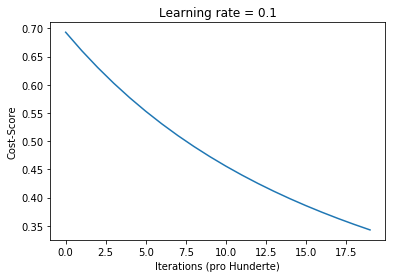

In [28]:
import matplotlib.pyplot as plt

costs = np.squeeze(model['costs'])
plt.plot(costs)
plt.ylabel('Cost-Score')
plt.xlabel('Iterations (pro Hunderte)')
plt.title("Learning rate = " + str(model["learning_rate"]))
plt.show()

Umso länger wir trainierten, umso geringer wurde der Cost-Score.

<div class="alert alert-warning">
<b>Aufgabe:</b> Anspassung der Learning Rate und Iterationenanzahl
    
Probieren Sie Werte für die Learning Rate aus und passen sie die Iterationenanzahl beliebig an. Visualiseren Sie jede Anpassung und vergleichen Sie die Graphen.

</div>

## 11.4 Mögliche Fehler <a class="anchor" id="11-4"/>

- Fehlercode mit "sparse" in der Beschreibung → Daten wurden nicht mithilfe von `toarray()` in eine Dense Matrix transformiert.